In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve, classification_report, roc_auc_score, auc, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd
import seaborn as sns
import warnings
from google.colab import drive
import xgboost as xg
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pickle
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
data = pd.read_csv("/content/drive/MyDrive/NetworkFinalData/dataset_small.csv")

In [ ]:
data.shape

(58645, 112)

In [ ]:
data.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,qty_vowels_domain,domain_length,domain_in_ip,server_client_domain,...,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,qty_percent_params,params_length,tld_present_params,qty_params,email_in_url,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,14,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,14,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.334573,0,8560,4927,185,1,4,2,3598,0,0,0,0,0,0
1,4,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,38,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,32,0,0,...,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1.326223,-1,263283,8217,-1,1,4,1,3977,1,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,24,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,23,0,0,...,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,3.969207,1,26496,258,106,1,2,1,10788,0,0,0,0,0,0
3,2,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,38,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,25,0,0,...,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.495212,1,20013,2602,319,1,2,1,14339,1,0,0,0,0,1
4,1,1,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,46,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,19,0,0,...,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.177876,-1,41828,-1,-1,1,2,1,389,1,1,0,0,0,1


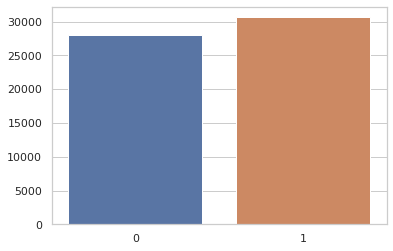

In [ ]:
target = data["phishing"].value_counts()
sns.barplot(x = target.keys(),
            y = target.values)

# Missing Values

In [ ]:
pd.DataFrame(data.isna().sum() ,
             columns=["naCount"]).\
             reset_index().\
             rename(columns = {"index" : "columnName" }).\
             sort_values(by = "naCount")

,columnName,naCount
0,qty_dot_url,0
81,qty_equal_params,0
80,qty_questionmark_params,0
79,qty_slash_params,0
78,qty_underline_params,0
...,...,...
31,qty_plus_domain,0
30,qty_comma_domain,0
29,qty_tilde_domain,0
110,url_shortened,0


- There is not any missing values in data

# Outliers

In [4]:
colsForOutlierAnalyze = [col for col in data.columns if len(data[col].value_counts().keys()) > 100]
colsForOutlierAnalyze

['length_url',
 'directory_length',
 'file_length',
 'params_length',
 'time_response',
 'asn_ip',
 'time_domain_activation',
 'time_domain_expiration',
 'ttl_hostname']

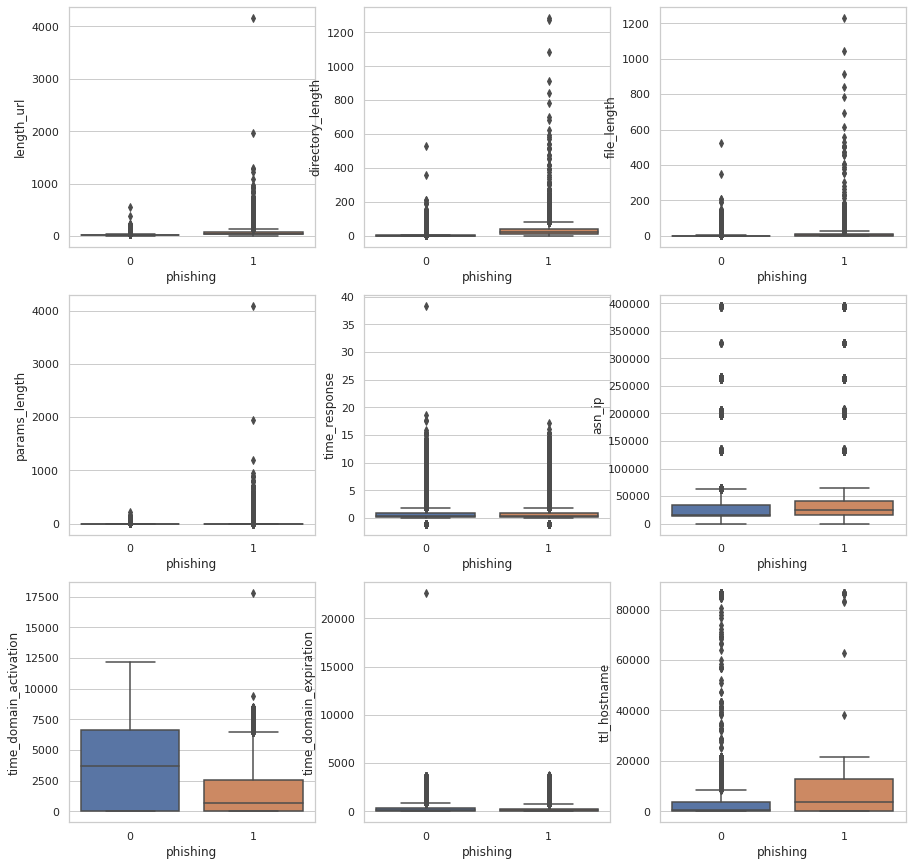

In [5]:
def boxPlot(data, colsForOutlierAnalyze):
## 
## Boxplots for detect outlier values
## @params = {data: dataset for analyze, colsForOutlierAnalyze: Numeric columns in dataset}
##
  plt.subplots(nrows = 3,
              ncols = 3,
              figsize = (15,15))
  for i in range(len(colsForOutlierAnalyze)):
    plt.subplot(3,3,i+1)
    sns.boxplot(x = "phishing", y = colsForOutlierAnalyze[i], data = data)
  #plt.title(colsForOutlierAnalyze[i])
boxPlot(data, colsForOutlierAnalyze)

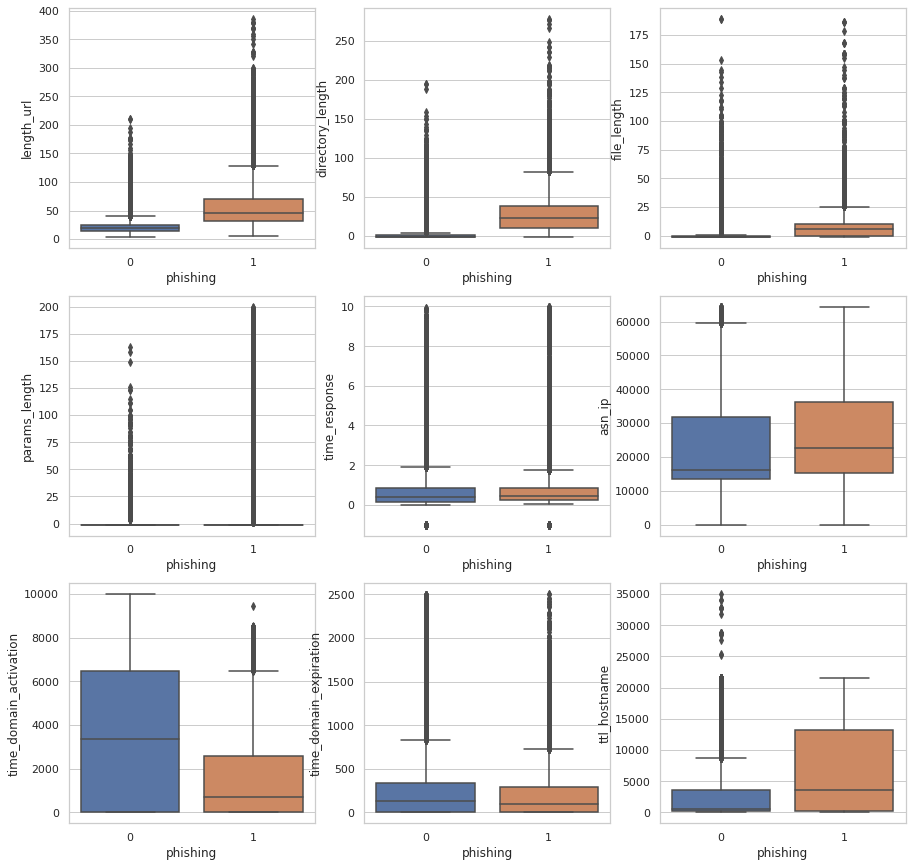

In [6]:
#outlierValues = (1000,700,700,1800,20,200000,10000,20000,60000)
outlierValues = (400,300,200,200,10,125000,10000,2500,35000)
def cleanOutliers(data, columnList, outlierValues):
##
## Clean outliers for a better predictive model.
## @params = {data: dataset for clean, columnList: list of numeric columns which are have outliers, outlierValues: pre-defined outlier values for each column}
## return = New dataframe which has not any outlier values / normalized data
##
  tempData = data
  for idx, column in enumerate(columnList):
    tempData.drop(tempData[tempData[column] > outlierValues[idx]].index, 
                  inplace = True)
  return tempData

dataCleanedOutliers = cleanOutliers(data, colsForOutlierAnalyze, outlierValues)
boxPlot(dataCleanedOutliers, colsForOutlierAnalyze)

In [7]:
dataCleanedOutliers.shape

(54023, 112)

# Train-Test Split

In [8]:
def trainTestSplitData(data, trainLen, valLen):
##
## Splits data for train (Model Training) and test (Model Evaluating)
## @params = {data: data for split, testLen: train data ratio}
## @returns = {x_train, x_test, y_train, y_test, x_val, y_val : base and target data for model}
##
  X = data.drop(["phishing"], axis = 1)
  y = data["phishing"]
  trainLen = int(data.shape[0] * trainLen)
  valLen = trainLen - int(trainLen * valLen)  
  x_train, x_test, y_train, y_test = X[:trainLen], X[trainLen:], y[:trainLen], y[trainLen:]
  x_train, x_val, y_train, y_val = x_train[:valLen], x_train[valLen:], y_train[:valLen], y_train[valLen:]
  del X
  del y
  return x_train, x_test, x_val, y_train, y_test, y_val

In [9]:
x_train, x_test, x_val, y_train, y_test, y_val = trainTestSplitData(dataCleanedOutliers, 0.9, 0.15)

In [10]:
print(f"Train Data Shape: {x_train.shape} Train Target Shape: {y_train.shape}")
print(f"Validation Data Shape: {x_val.shape} Validation Target Shape: {y_val.shape}")
print(f"Test Data Shape: {x_test.shape} Test Target Shape: {y_test.shape}")

Train Data Shape: (41327, 111) Train Target Shape: (41327,)
Validation Data Shape: (7293, 111) Validation Target Shape: (7293,)
Test Data Shape: (5403, 111) Test Target Shape: (5403,)


# Model Selection

In [ ]:
def gridSearchCrossValidation(tunedParams,
                              scores,
                              x_train,
                              x_val,
                              y_train,
                              y_val,
                              modelType = "KNN"
                              ):
  ###
  ### Cross Validation for test model metric and hyper-parameter tuning
  ### @params = {tunedParams: hyper-parameters for dataset, scores: accuracy metrics, x_train/y_train/x_val/y_val: datasets, modelType: algorithm type (KNN, RF, XGB)}
  ###
  for score in scores:
    print(f"Hyper-Parameter Tuning for {score}")
    if modelType == "KNN":
      model = GridSearchCV(KNeighborsClassifier(),
                           tunedParams,
                           scoring = f"{score}_macro")
    elif modelType == "RF":
      model = GridSearchCV((RandomForestClassifier()),
                           tunedParams,
                           scoring = f"{score}_macro")
    elif modelType == "XGB":
      model = GridSearchCV(xg.XGBClassifier(),
                           tunedParams,
                           scoring = f"{score}_macro")
    
    model.fit(x_train, y_train)
    print("Best parameters set found on development set:")
    print(model.best_params_)
    print("Grid scores on development set:")
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, model.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print("Detailed classification report:")
    y_true, y_pred = y_val, model.predict(x_val)
    print(classification_report(y_true, y_pred))

### K Nearest Neighbors

In [ ]:
tunedParams = [{"n_neighbors": [3,5,7],
                "weights": ["uniform", "distance"],
                "p": [1,2]}]
scores = ["precision", "recall"]
gridSearchCrossValidation(tunedParams,
                          scores,
                          x_train,
                          x_val,
                          y_train,
                          y_val,
                          modelType = "KNN")

Hyper-Parameter Tuning for precision
Best parameters set found on development set:
{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Grid scores on development set:
0.868 (+/-0.005) for {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.881 (+/-0.004) for {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
0.847 (+/-0.003) for {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
0.862 (+/-0.003) for {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
0.858 (+/-0.007) for {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.881 (+/-0.006) for {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
0.836 (+/-0.005) for {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.862 (+/-0.005) for {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
0.851 (+/-0.007) for {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
0.881 (+/-0.005) for {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
0.830 (+/-0.004) for {'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
0.862 (+/-0.006) for {'n_neighbors': 7, 'p': 2, 'weights': '

### Random Forest Classifier

In [ ]:
tunedParams = [{"n_estimators": [10, 50, 100],
                "criterion": ["gini", "entropy"],
                "max_features": ["auto", "sqrt", "log2"]}]
scores = ["precision", "recall"]
gridSearchCrossValidation(tunedParams,
                          scores,
                          x_train,
                          x_val,
                          y_train,
                          y_val,
                          modelType = "RF")

Hyper-Parameter Tuning for precision
Best parameters set found on development set:
{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100}
Grid scores on development set:
0.949 (+/-0.003) for {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 10}
0.953 (+/-0.002) for {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 50}
0.954 (+/-0.003) for {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 100}
0.948 (+/-0.005) for {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 10}
0.954 (+/-0.003) for {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 50}
0.954 (+/-0.003) for {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}
0.947 (+/-0.002) for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 10}
0.953 (+/-0.005) for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 50}
0.954 (+/-0.004) for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100}
0.949 (+/-0.003) for {'criter

### XGBoost Classifier

In [ ]:
tunedParams = [{"min_child_weight": [5, 10],
                "colsample_bytree": [0.6, 0.8]}]
scores = ["precision", "recall"]
gridSearchCrossValidation(tunedParams,
                          scores,
                          x_train,
                          x_val,
                          y_train,
                          y_val,
                          modelType = "XGB")

Hyper-Parameter Tuning for precision
Best parameters set found on development set:
{'colsample_bytree': 0.8, 'min_child_weight': 5}
Grid scores on development set:
0.929 (+/-0.004) for {'colsample_bytree': 0.6, 'min_child_weight': 5}
0.930 (+/-0.002) for {'colsample_bytree': 0.6, 'min_child_weight': 10}
0.930 (+/-0.003) for {'colsample_bytree': 0.8, 'min_child_weight': 5}
0.929 (+/-0.002) for {'colsample_bytree': 0.8, 'min_child_weight': 10}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      3549
           1       0.92      0.94      0.93      3744

    accuracy                           0.93      7293
   macro avg       0.93      0.93      0.93      7293
weighted avg       0.93      0.93      0.93      7293

Hyper-Parameter Tuning for recall
Best parameters set found on development set:
{'colsample_bytree': 0.8, 'min_child_weight': 5}
Grid scores on development set:
0.929 (+/-0.003) for {'colsample_b

- We select Random Forest Classifier with params = {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100}

# Model Evaluation

In [13]:
model = RandomForestClassifier(criterion = 'entropy', 
                               max_features = 'sqrt', 
                               n_estimators = 100)

In [14]:
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

<Figure size 1440x1440 with 0 Axes>

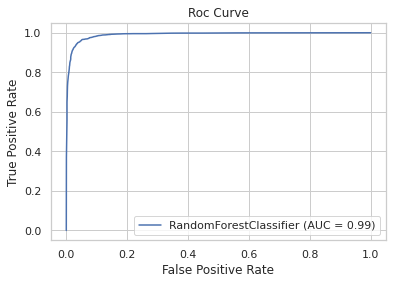

In [ ]:
plt.figure(figsize= (20,20))
plot_roc_curve(model, x_test, y_test)
plt.title("Roc Curve")
plt.show()

In [ ]:
predicts = model.predict(x_test)
predictionData = {"Index": range(x_test.shape[0]),
                      "Actual": y_test,
                      "Prediction": predicts}
predictionData = pd.DataFrame(predictionData)
predictionData

,Index,Actual,Prediction
52801,0,0,0
52802,1,1,1
52803,2,0,1
52804,3,1,1
52805,4,1,1
...,...,...,...
58640,5398,1,1
58641,5399,0,0
58642,5400,1,1
58643,5401,0,0


# Simple Neural Nets.

In [ ]:
def createCompileModel(nodeCounts,
                       input_dims,
                       loss,
                       optimizer):
  ###
  ### Create a basic neural nets with 4 layers
  ### @params = {nodeCounts: node count for each layer, input_dims: input layer dimensions, loss: loss function, optimizer: optimizer for model}
  ### @returns = {model: Compiled keras model}
  ###
  model = Sequential()
  model.add(Dense(nodeCounts[0], input_dim=input_dims, activation='relu'))
  model.add(Dense(nodeCounts[1], activation='relu'))
  model.add(Dense(nodeCounts[2], activation='relu'))
  model.add(Dense(nodeCounts[3], activation='sigmoid'))
  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
  return model

nodeCounts = [128,64,16,1]
loss = "binary_crossentropy"
optimizer = "adam"
model = createCompileModel(nodeCounts, x_train.shape[1], loss, optimizer)
model.fit(x_train, y_train, epochs=100, batch_size=256)

Epoch 1/100
162/162 [==============================] - 1s 3ms/step - loss: 50.4039 - accuracy: 0.6513
Epoch 2/100
162/162 [==============================] - 1s 3ms/step - loss: 6.3386 - accuracy: 0.7475
Epoch 3/100
162/162 [==============================] - 1s 3ms/step - loss: 5.8273 - accuracy: 0.7611
Epoch 4/100
162/162 [==============================] - 1s 3ms/step - loss: 4.9966 - accuracy: 0.7868
Epoch 5/100
162/162 [==============================] - 1s 3ms/step - loss: 8.6756 - accuracy: 0.7567
Epoch 6/100
162/162 [==============================] - 0s 3ms/step - loss: 3.3712 - accuracy: 0.8173
Epoch 7/100
162/162 [==============================] - 0s 3ms/step - loss: 4.9931 - accuracy: 0.7899
Epoch 8/100
162/162 [==============================] - 1s 3ms/step - loss: 3.9903 - accuracy: 0.8082
Epoch 9/100
162/162 [==============================] - 1s 3ms/step - loss: 3.7126 - accuracy: 0.8045
Epoch 10/100
162/162 [==============================] - 0s 3ms/step - loss: 4.0521 - accur

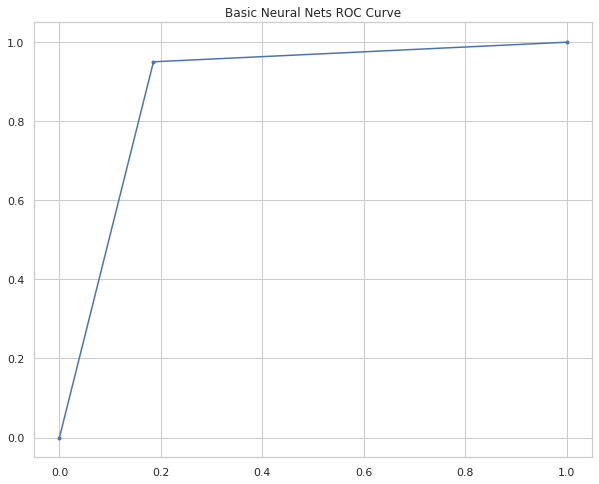

In [ ]:
def plotRocCurveNN(model, 
                   x_test,
                   y_test):
  ###
  ### Plotting roc curve for neural nets
  ### @params = {model: pre-trained nn model, x_test: test base, y_test: test target}
  ### @returns = {roc_auc_score: roc_auc score of nn model}
  ##
  predicts = model.predict_classes(x_test).ravel()
  fprNN, tprNN, thNN = roc_curve(y_test, predicts)
  aucModel = auc(fprNN, tprNN)
  plt.figure(figsize = (10,8))
  plt.plot(fprNN, tprNN, marker='.', label='Neural Network (auc = %0.3f)' % aucModel)
  plt.title("Basic Neural Nets ROC Curve")
  plt.show()
  return roc_auc_score(y_test, predicts)
rocAucScoreNN = plotRocCurveNN(model, x_test, y_test)

In [ ]:
rocAucScoreNN

0.882512126079879

In [ ]:
predicts = model.predict_classes(x_test).ravel()
predictionData = {"Index": range(x_test.shape[0]),
                      "Actual": y_test,
                      "Prediction": predicts}
predictionData = pd.DataFrame(predictionData)
predictionData

,Index,Actual,Prediction
52801,0,0,0
52802,1,1,1
52803,2,0,1
52804,3,1,1
52805,4,1,1
...,...,...,...
58640,5398,1,1
58641,5399,0,0
58642,5400,1,1
58643,5401,0,0


# Save Model

In [15]:
filename = 'finalizedRFModel.sav'
pickle.dump(model, open(filename, 'wb'))